# Fairness Checking: Equalized Odds Constraint Experiment
This notebook uses PuLP to solve the linear program outlined in the "Fairness Checking" document. Here, **we experiment with varying the upper bound constraint on w and see its effects on the objective value.**

In [0]:
!pip install pulp

     |████████████████████████████████| 13.6MB 4.5MB/s 
  Created wheel for pulp: filename=PuLP-1.6.10-cp36-none-any.whl size=12269903 sha256=048135c68ae5114dfa4643d884143de70149ab3eaa75e510db9e18a5745eec06
  Stored in directory: /root/.cache/pip/wheels/5e/76/77/e28b22219e46e3b4b033f02e8b36b2770ae545bdcf60c2b224
Successfully built pulp


In [0]:
import pandas as pd
import numpy as np
import pulp
import matplotlib.pyplot as plt

In [0]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


## Import Predicted Data
We take A (the protected attribute) to be the 'race' variable, and a = 0 while a' = 1. The last column, 'prediction,' is our f(X) variable, which can either be 0 or 1.

In [0]:
df = pd.read_csv('/content/drive/My Drive/colab/fairness_checking/predicted_dataset_scores.csv')

In [0]:
df.head(5)

,Unnamed: 0,Unnamed: 0.1,sex,age,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,two_year_recid,c_charge_degree_F,c_charge_degree_M,risk_recid,prediction_probs,prediction
0,3,0.000693,1.0,0.333333,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.0,0.0,0.033978,0
1,4,0.000832,1.0,0.294872,0.0,0.0,0.0,0.0,0.368421,1.0,1.0,0.0,1.0,0.822667,1
2,5,0.000970,1.0,0.320513,0.0,0.0,0.0,0.0,0.078947,0.0,1.0,0.0,0.0,0.223569,0
3,9,0.001664,0.0,0.243590,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.0,0.0,0.069368,0
4,16,0.002634,1.0,0.166667,0.0,0.0,0.0,0.0,0.131579,1.0,1.0,0.0,0.0,0.686681,1


In [0]:
len(df)

1232

In [0]:
# Our protected variable A is race, and a = 0 or a = 1. 
a = df['race']
np.asarray(a)
a_0_indices = []
a_1_indices = []

for i in range(len(a)):
    if a[i] == 0:
        a_0_indices.append(i)
    elif a[i] == 1:
        a_1_indices.append(i)

In [0]:
# Our true label Y is risk_recid, and y = 0 or y = 1. 
y = df['risk_recid']
np.asarray(y)
y_0_indices = []
y_1_indices = []

for i in range(len(y)):
    if y[i] == 0:
        y_0_indices.append(i)
    elif y[i] == 1:
        y_1_indices.append(i)

In [0]:
# Find the intersection of indices lists to make the pi's
a_0 = set(a_0_indices)
a_1 = set(a_1_indices)
y_0 = set(y_0_indices)
y_1 = set(y_1_indices)

a0_y0 = a_0.intersection(y_0) 
a0_y1 = a_0.intersection(y_1)
a1_y0 = a_1.intersection(y_0)
a1_y1 = a_1.intersection(y_1)

In [0]:
# Sanity check
print(len(a_0))
print(len(a0_y1) + len(a0_y0))
print(len(a_1))
print(len(a1_y1) + len(a1_y0))

609
609
623
623


In [0]:
# Our pi variables, pi_a_y are simply the proportions where we have A = a, Y = y
pi_0_0 = float(len(a0_y0))/(len(a_0_indices) + len(a_1_indices))
pi_0_1 = float(len(a0_y1))/(len(a_0_indices) + len(a_1_indices))
pi_1_0 = float(len(a1_y0))/(len(a_0_indices) + len(a_1_indices))
pi_1_1 = float(len(a1_y1))/(len(a_0_indices) + len(a_1_indices))

In [0]:
print(pi_0_0)
print(pi_0_1)
print(pi_1_0)
print(pi_1_1)

0.35064935064935066
0.14366883116883117
0.20454545454545456
0.30113636363636365


In [0]:
# Our prediction probability is under 'prediction_probs.' Notice that we use the 
# actual probability of the label, not the label itself.
f_X = df['prediction_probs']
np.asarray(f_X)

array([0.03397822, 0.8226671 , 0.22356904, ..., 0.9929936 , 0.3862658 ,
       0.35257342])

In [0]:
# Check if the dimensions match
print(len(f_X))
print(len(a0_y1) + len(a0_y0) + len(a1_y1) + len(a1_y0))

1232
1232


## Linear Program Function
Create a reusable function for each linear program.

The argument constraint is the constraint we want to set on the w's. This should be between 0 and 1.

The argument y_value should be Y = 0 or Y = 1, depending on which Y value we want to test EO on. 

In [0]:
# Input: function f(X), constraint, y_value (either 0 or 1)
# Output: (solved) model, weights
def EO_linear_prog(f_X, constraint, y_value):
  # Make sure constraint is within bounds
  assert(0 < constraint < 1)

  if(y_value != 0 and y_value != 1):
    return("Please enter 0 or 1 for the second argument (y_value).")
  
  # Define the linear program as a maximization problem
  model = pulp.LpProblem("Equalized Odds Fairness Checking", pulp.LpMaximize)
  
  # Our w variable in the objective
  # Lower bound constraint set here with lowBound=0 option
  w = pulp.LpVariable.dicts("w", (i for i in range(len(f_X))),lowBound=0, cat='Continuous')
  
  if(y_value == 0):
    # Objective Function
    model += pulp.lpSum(
      [(1./pi_0_0) * w[index] * f_X[index] for index in a0_y0] +
      [- (1./pi_1_0) * w[index] * f_X[index] for index in a1_y0])
    
    # Constraint that the \sum(w_i * 1{a = 0, y = 0}) = pi_0_0
    model += pulp.lpSum([w[index] for index in a0_y0]) == pi_0_0
    
    # Constraint that the \sum(w_i * 1{a = 0, y = 1}) = pi_0_1
    model += pulp.lpSum([w[index] for index in a1_y0]) == pi_1_0
    
  elif(y_value == 1):
    # Objective Function
    model += pulp.lpSum(
        [(1./pi_0_1) * w[index] * f_X[index] for index in a0_y1] +
        [- (1./pi_1_1) * w[index] * f_X[index] for index in a1_y1])
    
    # Constraint that the \sum(w_i * 1{a = 0, y = 1}) = pi_0_1
    model += pulp.lpSum([w[index] for index in a0_y1]) == pi_0_1
    
    # Constraint that the \sum(w_i * 1{a = 1, y = 1}) = pi_0_1
    model += pulp.lpSum([w[index] for index in a1_y1]) == pi_1_1
  
  # Constraint that the w's all sum to 1
  model += pulp.lpSum([w[i] for i in range(len(f_X))]) == 1

  # IMPORTANT: Constraint we set on the w's. Experiment with this
  for weight in w:
    model += w[weight] <= constraint
  
  # Solve the linear program
  model.solve()
  
  return model, w

# Get the results
def weights_dictionary(w):
  results_dict = dict()
  for i in range(len(f_X)):
    results_dict[i] = w[i].varValue
  return results_dict

## Experiment with Linear Program (Y = 0)
We use the PuLP package to solve our linear program. Iterate over 99 constraints (from 0.01 to 0.99) and see how that affects the objective value. 

In [0]:
constraint_granule = 0.01
constraints = []
y0_objective_values = []

# Iterate over constraints
for i in range(1, 100):
  model, weights = EO_linear_prog(f_X, constraint_granule * i, 0)
  y0_objective_values.append(pulp.value(model.objective))
  constraints.append(constraint_granule * i)

Text(0.5, 1.0, 'Upper Bound Constraint on w vs. EO LP Objective Value (Y = 0)')

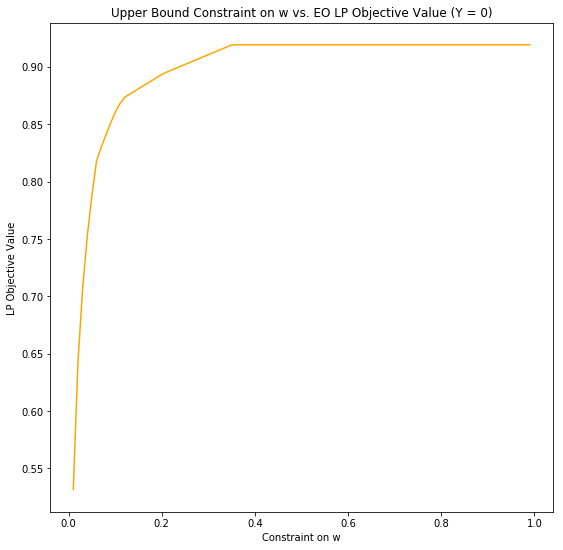

In [0]:
# Plot the constraints vs. objective values
plt.figure(figsize=(9,9))
plt.plot(constraints, y0_objective_values, 'orange')
plt.xlabel('Constraint on w')
plt.ylabel('LP Objective Value')
plt.title('Upper Bound Constraint on w vs. EO LP Objective Value (Y = 0)')

## Experiment with Linear Program (Y = 1)
We use the PuLP package to create our linear program. Iterate over 99 constraints (from 0.01 to 0.99) and see how that affects the objective value. 

In [0]:
constraint_granule = 0.01
constraints = []
y1_objective_values = []

# Iterate over constraints
for i in range(1, 100):
  model, weights = EO_linear_prog(f_X, constraint_granule * i, 1)
  y1_objective_values.append(pulp.value(model.objective))
  constraints.append(constraint_granule * i)

Text(0.5, 1.0, 'Upper Bound Constraint on w vs. EO LP Objective Value (Y = 1)')

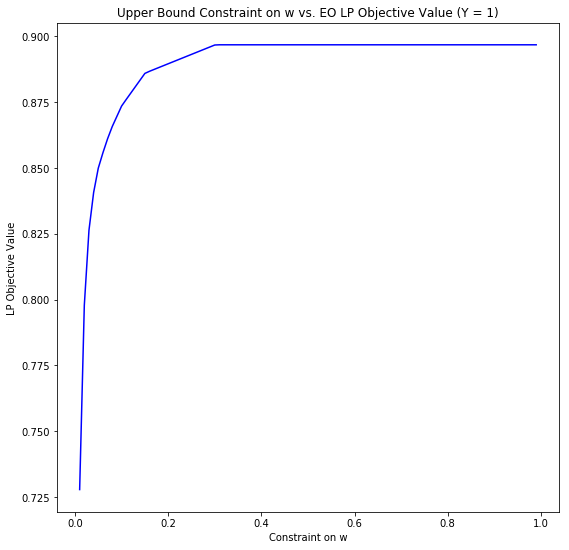

In [0]:
# Plot the constraints vs. objective values
plt.figure(figsize=(9,9))
plt.plot(constraints, y1_objective_values, 'blue')
plt.xlabel('Constraint on w')
plt.ylabel('LP Objective Value')
plt.title('Upper Bound Constraint on w vs. EO LP Objective Value (Y = 1)')

## Plot Y = 0 and Y = 1 Together

Text(0.5, 1.0, 'Upper Bound Constraint on w vs. EO LP Objective Value')

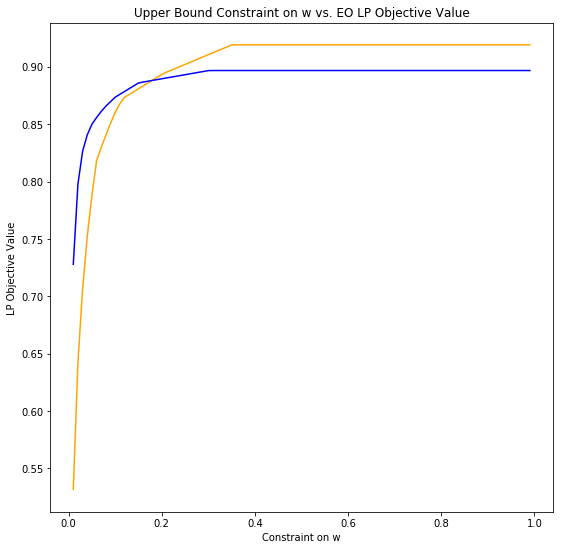

In [0]:
# Plot the constraints vs. objective values
plt.figure(figsize=(9,9))
plt.plot(constraints, y0_objective_values, 'orange')
plt.plot(constraints, y1_objective_values, 'blue')
plt.xlabel('Constraint on w')
plt.ylabel('LP Objective Value')
plt.title('Upper Bound Constraint on w vs. EO LP Objective Value')

In [0]:
# Save as a CSV
df = pd.DataFrame({'Constraints':constraints, 'EO LP Objective Values (Y = 0)':y0_objective_values, 'EO LP Objective Values (Y = 1)':y1_objective_values})
df.head(5)

,Constraints,EO LP Objective Values (Y = 0),EO LP Objective Values (Y = 1)
0,0.01,0.531486,0.727811
1,0.02,0.642378,0.797789
2,0.03,0.706092,0.826327
3,0.04,0.752133,0.840648
4,0.05,0.787948,0.849914


In [0]:
df.to_csv('/content/drive/My Drive/colab/fairness_checking/eo_100_constraints.csv')